# Particle Swarm Optimization (PSO) for University Timetable Scheduling

## Setup and Imports

In [ ]:
#Requirements
#!pip install deap 
#!pip install pandas tabulate

In [1]:
from deap import base
from deap import creator
from deap import tools
#from tabulate import tabulate (tl3 shaklo msh helw)
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import configparser

## Constants

In [2]:
NUM_COURSES = 20    # 20 course, each level take 5 courses
NUM_LECTURERS = 10
NUM_TIMESLOTS = 25  # 5 timeslots per day over a 5-day week
NUM_ROOMS = 5
POPULATION_SIZE = 2000 #Assume average 500 student per each level
MAX_GENERATIONS = 700
COURSE_HOURS = np.random.randint(1, 4, size=NUM_COURSES)  # Random between 1 to 3 hours per course
POPULAR_COURSE_COMBINATIONS = [
    (0, 1, 2, 3, 16, 17),  # Courses 0, 1,2 and 3 are often taken together For Level 1
    (4, 5, 6, 7, 18, 19),     # another common combination For Level 2
    (8, 9, 10, 11, 20, 21),# For Level 3
    (12, 13, 14, 15, 22, 23)# For Level 4
]
# Constants for days and timeslots
NUM_DAYS = 5
TIMESLOTS_PER_DAY = 5
NUM_TIMESLOTS = NUM_DAYS * TIMESLOTS_PER_DAY
DAYS = ["Saturday", "Monday", "Tuesday", "Wednesday", "Thursday"]
TIMESLOTS = [f"{i+8}:00-{i+10}:00" for i in range(TIMESLOTS_PER_DAY)]

# Let's simulate some data for demonstration
# Each row represents a lecturer's availability over timeslots, 0 means unavailable
LECTURER_AVAILABILITY = np.random.choice([0, 1], (NUM_LECTURERS, NUM_TIMESLOTS), p=[0.2, 0.8])

# Course requirements indicating which lecturer can teach which course
# 0 means the lecturer cannot teach the course, 1 means they can
COURSE_REQUIREMENTS = np.random.choice([0, 1], (NUM_COURSES, NUM_LECTURERS))

# Room capacity 
ROOM_CAPACITY = np.random.randint(10, 100, size=NUM_ROOMS)

In [3]:
# we assumed 16 course, each level take 4 courses 
def course_to_level(course_id):
    for level_index, courses in enumerate(POPULAR_COURSE_COMBINATIONS):
        if course_id in courses:
            return level_index
    return None  # In case the course_id is not found


## Particle and Problem Encoding

In [4]:
# Create a Particle Class with appropriate attributes
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))  # We aim to minimize the fitness
creator.create("Particle", list, fitness=creator.FitnessMin, best=None, speed=list)

def create_particle():
    particle = []
    used_slots = set()  # Track used timeslots
    for course_id in range(NUM_COURSES):
        valid = False
        while not valid:
            lecturer_id = random.choice([i for i, can_teach in enumerate(COURSE_REQUIREMENTS[course_id]) if can_teach == 1])
            room_id = random.randint(0, NUM_ROOMS - 1)
            timeslot_id = random.randint(0, NUM_TIMESLOTS - 1)
            day_id = timeslot_id // len(TIMESLOTS)
            
            # Ensure the course isn't already scheduled on this day
            if (course_id, day_id) not in used_slots:
                particle.append((course_id, lecturer_id, room_id, timeslot_id))
                used_slots.add((course_id, day_id))
                valid = True
    return creator.Particle(particle)

## Update Particle

In [5]:
def update_particle(particle, best, coeff_inertia=0.5, coeff_cognitive=0.5, coeff_social=0.5):
    new_particle = []
    for idx, (course_id, lecturer_id, room_id, timeslot_id) in enumerate(particle):
        # Introduce shift based on weighted sum of inertia, cognitive, and social components
        shift = random.randint(-3, 3) * coeff_inertia + \
                (particle.best[idx][3] - timeslot_id) * coeff_cognitive + \
                (best[idx][3] - timeslot_id) * coeff_social
        
        new_timeslot = (timeslot_id + int(shift)) % NUM_TIMESLOTS

        # Make sure the new timeslot is valid
        if LECTURER_AVAILABILITY[lecturer_id][new_timeslot] == 1:
            new_particle.append((course_id, lecturer_id, room_id, new_timeslot))
        else:
            new_particle.append((course_id, lecturer_id, room_id, timeslot_id))
    particle[:] = new_particle

In [7]:
'''''
def update_particle(particle, best, gen, max_gen):
    # Linearly decreasing inertia weight
    w_start = float(config['PSO']['INERTIA_WEIGHT'])
    w_end = 0.4  # Lower bound of inertia weight
    w = w_start - (w_start - w_end) * (gen / max_gen)
    
    phi1 = float(config['PSO']['COGNITIVE_COEFFICIENT'])
    phi2 = float(config['PSO']['SOCIAL_COEFFICIENT'])
    
    u1, u2 = np.random.uniform(0, 1), np.random.uniform(0, 1)
    v_u1 = phi1 * u1 * (particle.best - particle)
    v_u2 = phi2 * u2 * (best - particle)
    particle.speed = w * particle.speed + v_u1 + v_u2
    particle[:] = particle + particle.speed
    particle[:] = np.clip(particle, 0, NUM_TIMESLOTS - 1)

'''''

"''\ndef update_particle(particle, best, gen, max_gen):\n    # Linearly decreasing inertia weight\n    w_start = float(config['PSO']['INERTIA_WEIGHT'])\n    w_end = 0.4  # Lower bound of inertia weight\n    w = w_start - (w_start - w_end) * (gen / max_gen)\n    \n    phi1 = float(config['PSO']['COGNITIVE_COEFFICIENT'])\n    phi2 = float(config['PSO']['SOCIAL_COEFFICIENT'])\n    \n    u1, u2 = np.random.uniform(0, 1), np.random.uniform(0, 1)\n    v_u1 = phi1 * u1 * (particle.best - particle)\n    v_u2 = phi2 * u2 * (best - particle)\n    particle.speed = w * particle.speed + v_u1 + v_u2\n    particle[:] = particle + particle.speed\n    particle[:] = np.clip(particle, 0, NUM_TIMESLOTS - 1)\n\n"

## Fitness Evaluation

In [6]:
## Advanced Fitness Evaluation with Gaping Conflict
def evaluate(particle):
    conflicts = 0
    penalties = {
        "lecturer_conflict": 10,     # Severe conflict
        "room_conflict": 5,          # Moderate conflict
        "availability_conflict": 3,  # Basic conflict
        "level_conflict": 10,         # Severe conflict
        "gaping_conflict": 1         # Least severe conflict
    }
    lecturer_time_conflict = {}
    room_time_conflict = {}
    level_timeslot_conflict = {}
    level_day_timeslots = {}  # Tracks course timeslots by level and day

    for course_id, lecturer_id, room_id, timeslot_id in particle:
        # Check for lecturer conflicts
        if timeslot_id in lecturer_time_conflict and lecturer_id in lecturer_time_conflict[timeslot_id]:
            conflicts += penalties["lecturer_conflict"]
        else:
            lecturer_time_conflict.setdefault(timeslot_id, []).append(lecturer_id)

        # Check room capacity conflicts
        if timeslot_id in room_time_conflict and room_id in room_time_conflict[timeslot_id]:
            conflicts += penalties["room_conflict"]
        else:
            room_time_conflict.setdefault(timeslot_id, {}).setdefault(room_id, []).append(course_id)

        # Check lecturer availability
        if LECTURER_AVAILABILITY[lecturer_id][timeslot_id] == 0:
            conflicts += penalties["availability_conflict"]

        # Check level scheduling and gaping conflicts
        course_level = course_to_level(course_id)
        day_id = timeslot_id // TIMESLOTS_PER_DAY
        if course_level not in level_day_timeslots:
            level_day_timeslots[course_level] = {}
        if day_id not in level_day_timeslots[course_level]:
            level_day_timeslots[course_level][day_id] = []
        level_day_timeslots[course_level][day_id].append(timeslot_id)

    # Check for gaping conflicts within each level and day
        course_level = course_to_level(course_id)
        if course_level in level_timeslot_conflict and timeslot_id in level_timeslot_conflict[course_level]:
            conflicts += penalties["level_conflict"]
        else:
            level_timeslot_conflict.setdefault(course_level, []).append(timeslot_id)


    return conflicts,



## PSO Configuration

In [7]:
toolbox = base.Toolbox()
toolbox.register("particle", create_particle)
toolbox.register("population", tools.initRepeat, list, toolbox.particle)
toolbox.register("update", update_particle)
toolbox.register("evaluate", evaluate)

## Main Function to Run PSO

In [8]:
def main():
    # set the random seed:
    RANDOM_SEED = 42
    np.random.seed(RANDOM_SEED)  # Seed for NumPy functions
    random.seed(RANDOM_SEED)
    population = toolbox.population(n=POPULATION_SIZE)
    best = None
    for _ in range(MAX_GENERATIONS):
        for part in population:
            part.fitness.values = toolbox.evaluate(part)
            if not part.best or part.best.fitness < part.fitness:
                part.best = creator.Particle(part)
                part.best.fitness.values = part.fitness.values
            if not best or best.fitness < part.fitness:
                best = creator.Particle(part)
                best.fitness.values = part.fitness.values
    print("Best Particle =", best)
    print("Best Fitness:", best.fitness.values[0])
    
   
    

    # Organize schedule by level
    level_schedules = {
        i: {day: {timeslot: [] for timeslot in TIMESLOTS} for day in DAYS}
        for i in range(len(POPULAR_COURSE_COMBINATIONS))
    }

    for course_id, lecturer_id, room_id, timeslot_id in best:
        for level_index, courses in enumerate(POPULAR_COURSE_COMBINATIONS):
            if course_id in courses:
                day_index = timeslot_id // len(TIMESLOTS)
                time_index = timeslot_id % len(TIMESLOTS)
                day = DAYS[day_index]
                time = TIMESLOTS[time_index]
                entry = f"C{course_id} L{lecturer_id} R{room_id}"
                level_schedules[level_index][day][time].append(entry)

    # Generate and display tables for each level using matplotlib
    for level, schedule in level_schedules.items():
        fig, ax = plt.subplots(figsize=(10, 5))  # Adjust size as needed
        table_data = [[schedule[day][time] for time in TIMESLOTS] for day in DAYS]
        table = ax.table(cellText=table_data, colLabels=TIMESLOTS, rowLabels=DAYS, cellLoc='center', loc='center', colColours=['#ffe5e5']*len(TIMESLOTS))
        ax.set_title(f"Timetable for Level {level + 1}")
        ax.axis('tight')
        ax.axis('off')
        table.auto_set_font_size(False)
        table.set_fontsize(8)  # Adjust font size for better readability
        table.scale(1, 1.5)  # Adjust table scale for spacing
        plt.show()

    # Print all levels in the same table
    # Prepare to aggregate courses in the same timeslot
    schedule = {day: {timeslot: [] for timeslot in TIMESLOTS} for day in DAYS}

    for course_id, lecturer_id, room_id, timeslot_id in best:
        day_index = timeslot_id // len(TIMESLOTS)
        time_index = timeslot_id % len(TIMESLOTS)
        day = DAYS[day_index]
        time = TIMESLOTS[time_index]
        entry = f"Course{course_id} Lecturer{lecturer_id} Room{room_id}"
        schedule[day][time].append(entry)

    # Convert lists to comma-separated strings for display
    for day in DAYS:
        for timeslot in TIMESLOTS:
            schedule[day][timeslot] = "\n".join(schedule[day][timeslot])

    # Creating a table with matplotlib
    fig, ax = plt.subplots(figsize=(12, 8))  # Larger figure size for better readability
    ax.set_axis_off()
    table_data = [[schedule[day][time] for time in TIMESLOTS] for day in DAYS]
    table = ax.table(cellText=table_data, colLabels=TIMESLOTS, rowLabels=DAYS, cellLoc='center', loc='center', colColours=['#ffe5e5']*len(TIMESLOTS))
    table.auto_set_font_size(False)
    table.set_fontsize(12)  # Adjusted for better fit
    table.scale(1.4, 3.9)  # Increased scaling for more space per cell
    plt.title("Detailed Course Schedule with Rooms", fontsize=15)
    plt.show()

    return best

Best Particle = [(0, 2, 2, 1), (1, 5, 1, 11), (2, 8, 3, 9), (3, 8, 0, 18), (4, 3, 3, 20), (5, 9, 1, 18), (6, 6, 0, 10), (7, 2, 1, 21), (8, 5, 0, 5), (9, 9, 4, 8), (10, 6, 1, 20), (11, 0, 1, 2), (12, 5, 4, 19), (13, 1, 2, 16), (14, 7, 4, 0), (15, 6, 1, 9), (16, 2, 0, 7), (17, 2, 4, 23), (18, 7, 3, 15), (19, 2, 4, 13)]
Best Fitness: 3.0


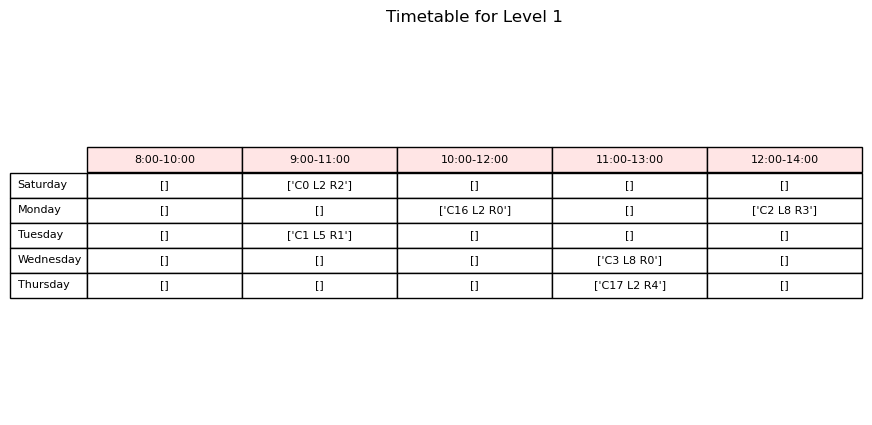

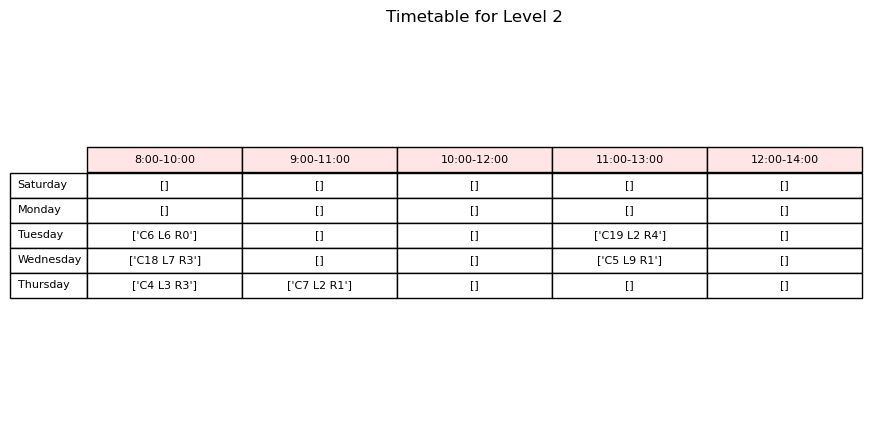

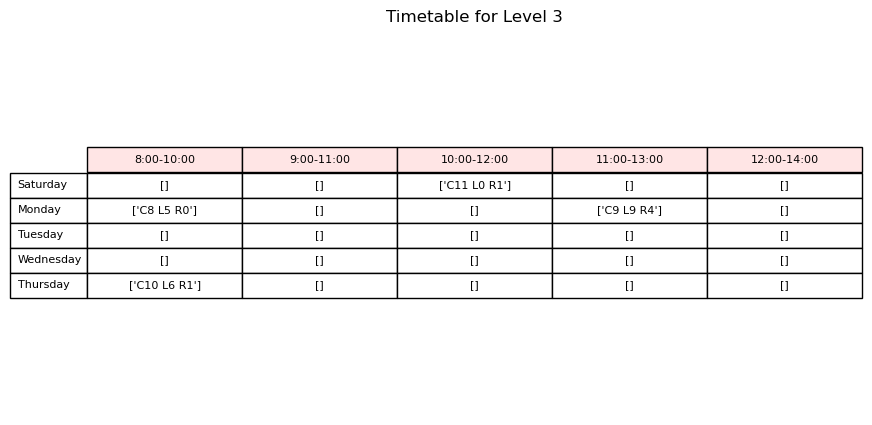

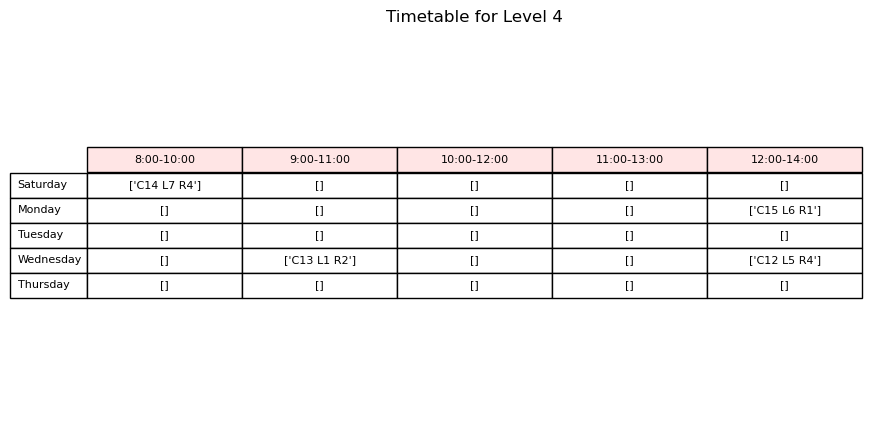

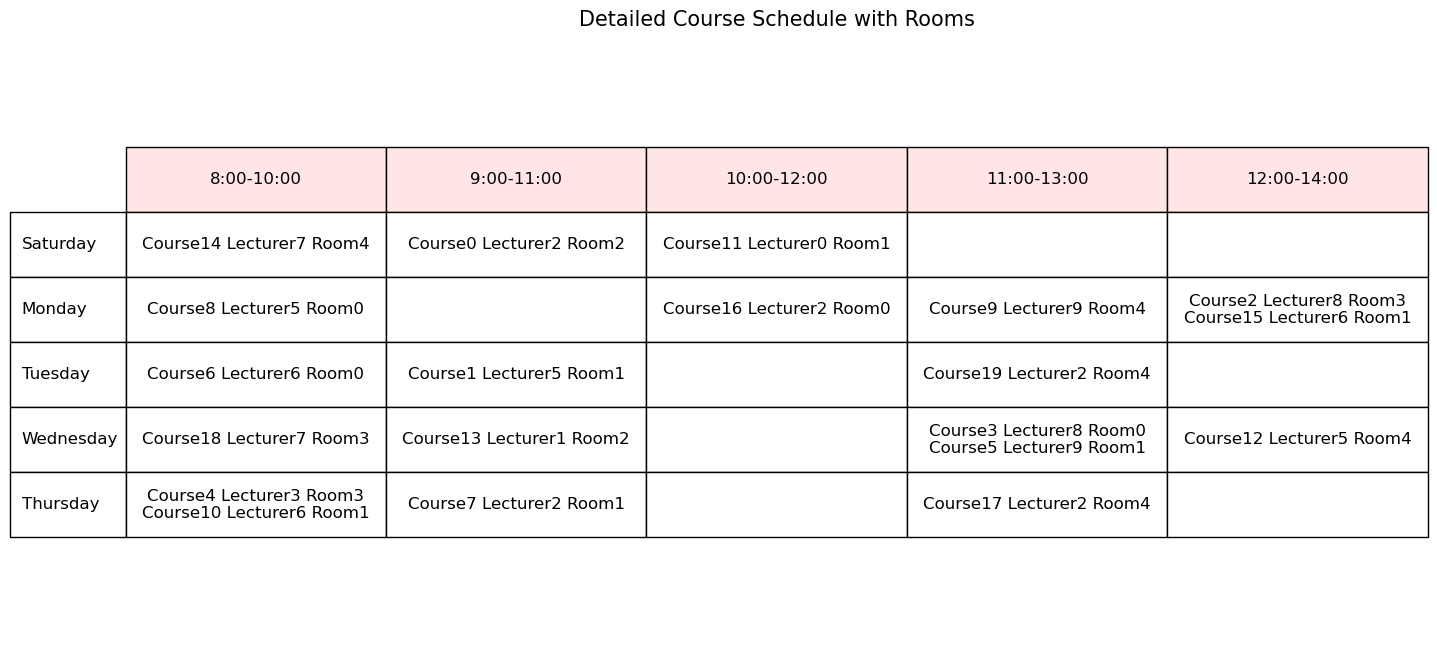

In [9]:
if __name__ == "__main__":
    best_solution = main()
     

In [10]:
if __name__ == "__main__":
    for idx, (course_id, lecturer_id, room_id, timeslot_id) in enumerate(best_solution):
        print(f"Course {course_id}: Lecturer {lecturer_id}, Room {room_id}, Timeslot {timeslot_id}")


Course 0: Lecturer 5, Room 1, Timeslot 5
Course 1: Lecturer 0, Room 1, Timeslot 6
Course 2: Lecturer 1, Room 4, Timeslot 4
Course 3: Lecturer 2, Room 1, Timeslot 15
Course 4: Lecturer 1, Room 2, Timeslot 2
Course 5: Lecturer 1, Room 1, Timeslot 16
Course 6: Lecturer 7, Room 3, Timeslot 21
Course 7: Lecturer 6, Room 2, Timeslot 9
Course 8: Lecturer 1, Room 1, Timeslot 17
Course 9: Lecturer 8, Room 3, Timeslot 24
Course 10: Lecturer 7, Room 3, Timeslot 11
Course 11: Lecturer 6, Room 4, Timeslot 10
Course 12: Lecturer 7, Room 0, Timeslot 19
Course 13: Lecturer 5, Room 1, Timeslot 20
Course 14: Lecturer 9, Room 2, Timeslot 22
Course 15: Lecturer 2, Room 3, Timeslot 17
Course 16: Lecturer 4, Room 3, Timeslot 22
Course 17: Lecturer 7, Room 0, Timeslot 17
Course 18: Lecturer 4, Room 2, Timeslot 5
Course 19: Lecturer 0, Room 2, Timeslot 14


# User Interaction

## Show Student's Timetable

In [11]:
def display_courses_by_level(level):
    if level < 1 or level > len(POPULAR_COURSE_COMBINATIONS):
        print("Invalid level. Please choose a valid student level between 1 and", len(POPULAR_COURSE_COMBINATIONS))
        return []
    courses = POPULAR_COURSE_COMBINATIONS[level - 1]
    print("Courses available for Level", level, ":")
    for course_id in courses:
        print("Course ID:", course_id)
    return courses


In [ ]:
def display_timetable_for_selected_courses(best, selected_courses):
    # Filter the schedule for selected courses
    filtered_schedule = {day: {timeslot: [] for timeslot in TIMESLOTS} for day in DAYS}
    for course_id, lecturer_id, room_id, timeslot_id in best:
        if course_id in selected_courses:
            day_index = timeslot_id // len(TIMESLOTS)
            time_index = timeslot_id % len(TIMESLOTS)
            day = DAYS[day_index]
            time = TIMESLOTS[time_index]
            entry = f"C{course_id} L{lecturer_id} R{room_id}"
            filtered_schedule[day][time].append(entry)

    # Create and display the timetable with matplotlib
    fig, ax = plt.subplots(figsize=(10, 5))  # Adjust size as needed
    table_data = [[filtered_schedule[day][time] for time in TIMESLOTS] for day in DAYS]
    table = ax.table(cellText=table_data, colLabels=TIMESLOTS, rowLabels=DAYS, cellLoc='center', loc='center', colColours=['#ffe5e5']*len(TIMESLOTS))
    ax.set_title("Timetable for Selected Courses")
    ax.axis('tight')
    ax.axis('off')
    table.auto_set_font_size(False)
    table.set_fontsize(8)  # Adjust font size for better readability
    table.scale(1, 1.5)  # Adjust table scale for spacing
    plt.show()


In [ ]:
# Allow user to select a level
level = int(input("Enter your student level (1-4): "))
available_courses = display_courses_by_level(level)
    
# Allow user to select courses from the available ones
selected_course_ids = input("Enter the course IDs you want to include in your timetable, separated by commas: ")
selected_course_ids = [int(id.strip()) for id in selected_course_ids.split(',') if int(id.strip()) in available_courses]
# Display timetable for the selected courses
display_timetable_for_selected_courses(best_solution, selected_course_ids)